# SEM 2D BSE Imaging: GaN Dislocations 

**Example Data: GaN_Dislocations_1**

This is an example notebook to demonstrate angle resolved BSE imaging via signal extraction from raw, saved, EBSD patterns of a GaN thin film sample containing dislocations.
As we will see below, the BSE signal from the raw EBSD patterns clearly shows the presence of dislocations in the GaN sample. This is because suitable incident beam channeling conditions have been carefully chosen before the actual measurement, i.e. the dislocation are usually not seen in an arbitrary measurement geometry.

The raw EBSD signal is dominated by the background BSE contribution, which varies according to the changes of the incident beam conditions relative to the strained and rotated crystal structure near the dislocations.
For this specific experimental measurement, the analysis of the processed Kikuchi patterns also shows that 
the expected influences of the dislocations on the outgoing Kikuchi signal are not seen by the 7x7 virtual BSE detector arrangement (i.e. we see basically only noise using the 7x7 array approach).

In [1]:
# directory with the HDF5 EBSD pattern file:
data_dir = "../../../xcdskd_reference_data/GaN_Dislocations_1/hdf5/"

# filename of the HDF5 file:
hdf5_filename =  "GaN_Dislocations_1.hdf5"

# verbose output
output_verbose = False

Necessary packages

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# ignore divide by Zero
np.seterr(divide='ignore', invalid='ignore')

import time, sys, os
import h5py
import skimage.io 

from aloe.plots import normalizeChannel, make2Dmap, get_vrange
from aloe.plots import plot_image, plot_SEM, plot_SEM_RGB
from aloe.image import arbse
from aloe.image.downsample import downsample
from aloe.image.kikufilter import process_ebsp
from aloe.io.progress import print_progress_line

In [3]:
# make result dirs and filenames
h5FileNameFull=os.path.abspath(data_dir + hdf5_filename)
h5FileName, h5FileExt = os.path.splitext(h5FileNameFull)
h5FilePath, h5File = os.path.split(h5FileNameFull)
timestr = time.strftime("%Y%m%d-%H%M%S")
h5ResultFile="arBSE_" + hdf5_filename
    

# close HDF5 file if still open
if 'f' in locals():
    f.close()    
f=h5py.File(h5FileName+h5FileExt, "r")

ResultsDir = h5FilePath+"/arBSE_" + timestr + "/" 
CurrentDir = os.getcwd()
#print('Current Directory: '+CurrentDir)
#print('Results Directory: '+ResultsDir)
if not os.path.isdir(ResultsDir):
    os.makedirs(ResultsDir)
os.chdir(ResultsDir)

if output_verbose:
    print('HDF5 full file name: ', h5FileNameFull)
    print('HDF5 File: ', h5FileName+h5FileExt)
    print('HDF5 Path: ', h5FilePath)
    print('Results Directory: ', ResultsDir)
    print('Results File: ', h5ResultFile)

In [4]:
DataGroup="/Scan/EBSD/Data/"
HeaderGroup="/Scan/EBSD/Header/"
Patterns = f[DataGroup+"RawPatterns"]
#StaticBackground=f[DataGroup+"StaticBackground"]
XIndex =   f[DataGroup+"X BEAM"]
YIndex =   f[DataGroup+"Y BEAM"]
MapWidth = f[HeaderGroup+"NCOLS"].value
MapHeight= f[HeaderGroup+"NROWS"].value
PatternHeight=f[HeaderGroup+"PatternHeight"].value
PatternWidth =f[HeaderGroup+"PatternWidth"].value
print('Pattern Height: ', PatternHeight)
print('Pattern Width : ', PatternWidth)
PatternAspect=float(PatternWidth)/float(PatternHeight)
print('Pattern Aspect: '+str(PatternAspect))
print('Map Height: ', MapHeight)
print('Map Width : ', MapWidth)

step_map_microns = f[HeaderGroup+"X Resolution"].value
print('Map Step Size (microns): ', step_map_microns)

Pattern Height:  256
Pattern Width :  336
Pattern Aspect: 1.3125
Map Height:  50
Map Width :  52
Map Step Size (microns):  0.05


Check Optional Pattern Processing

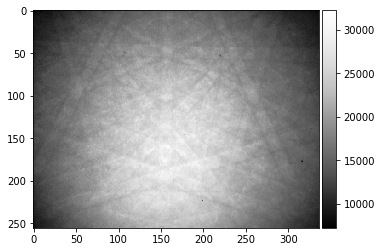

In [5]:
ipattern = 215
raw_pattern=Patterns[ipattern,:,:]
plot_image(raw_pattern)
skimage.io.imsave('pattern_raw_' + str(ipattern) + '.tiff', raw_pattern, plugin='tifffile')

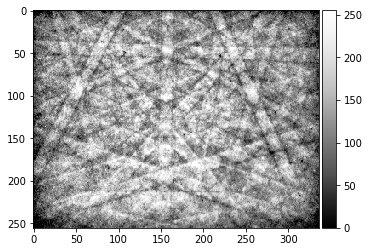

In [6]:
# make processed pattern without static background
processed_pattern = process_ebsp(raw_pattern, binning=1)
plot_image(processed_pattern)
skimage.io.imsave('pattern_processed_' + str(ipattern) + '.tiff', processed_pattern, plugin='tifffile')

In [7]:
try:
    # get static background from HDF5, cut off first lines to fit to Patterns
    background_static_file = f[HeaderGroup+"StaticBackground"]
    plot_image(background_static_file, title="Static Background from HDF5 File")
except:
    print('WARNING: No static background found in HDF5 file.')
    background_static_file = None

**Static Background from Pattern Average in the Map**

We can also approximate a static background from the EBSD map itself; or even use an extra map that was taken explicitly for making a background, e.g. from the sample holder.
For polycrystalline samples with a large enough number of  grains in random orientations, the Kikuchi patterns from all grains will average out when taking the average of all pattern.
For single crystalline samples, or samples with a low number of different orientation present in the map area measured, the average of all patterns will stay contain Kikuchi diffraction features. These features in the static background will tend to produce artififacts when the raw data is processed using the background with diffraction features. 

In [8]:
# load background from different experiment
#background_static_txt = np.loadtxt(data_dir + "background_static.txt")
#plot_image(background_static_txt, title="background_static.txt")

In [9]:
# assign static background
background_static_image = skimage.io.imread("../StaticBackground.tiff") #, plugin='tifffile') 

(256, 336)
[[2884 2920 2920 ..., 2994 2995 2992]
 [2910 2944 2954 ..., 3005 3009 2992]
 [2931 2955 2954 ..., 3050 3024 3036]
 ..., 
 [3725 3774 3783 ..., 4260 4243 4211]
 [3714 3761 3722 ..., 4297 4266 4221]
 [3704 3707 3737 ..., 4279 4220 4204]]


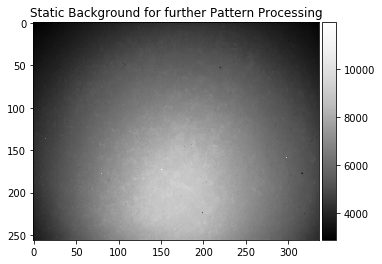

In [10]:
#background_static = background_static_file
#background_static = background_static_txt
background_static = background_static_image
print(background_static.shape)
print(background_static)
plot_image(background_static, title="Static Background for further Pattern Processing")

In [11]:
#skimage.io.imsave('background_static.tiff', background_static, plugin='tifffile') # this will be 16bit only
np.savetxt('background_static.txt', background_static)

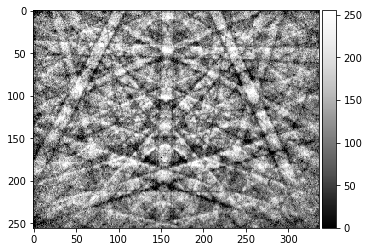

In [12]:
# note the CCD halves and static background dust, hot pixels
processed_pattern = process_ebsp(raw_pattern, static_background=background_static, binning=1)
plot_image(processed_pattern)
skimage.io.imsave('pattern_processed_static_' + str(ipattern) + '.tiff', processed_pattern, plugin='tifffile')

**Specification of Image Pre-Processing Functions**

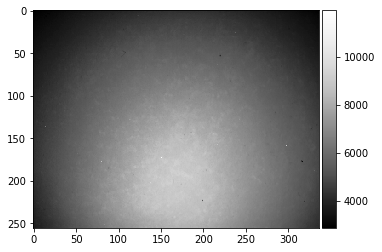

(256, 336)


In [13]:
prebinning=1
background_static_binned = downsample(background_static, prebinning)

def pipeline_process(pattern, prebinning=1, kikuchi=False):
    if prebinning>1:
        pattern = downsample(pattern, prebinning)
    if kikuchi:
        return process_ebsp(pattern, static_background=background_static_binned, binning=1)
    else:
        return pattern
    
def process_kikuchi(pattern):
    return pipeline_process(pattern, prebinning=prebinning, kikuchi=True)

def process_bin(pattern):
    return pipeline_process(pattern, prebinning=prebinning, kikuchi=False)

plot_image(background_static_binned)
print(background_static_binned.shape)

##  vBSE Array

We convert the raw pattern into a 7x7 array of vBSE sensor intensities.

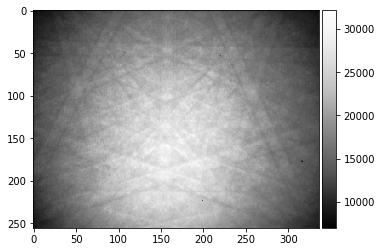

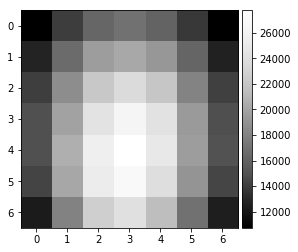

In [14]:
pattern = pipeline_process(Patterns[1000], kikuchi=False)
vbse = arbse.rebin_array(pattern)
plot_image(pattern)
plot_image(vbse)

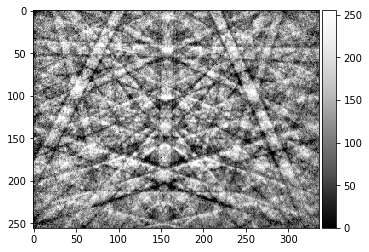

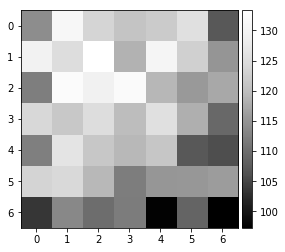

In [15]:
pattern = process_kikuchi(Patterns[1000])
vkiku = arbse.rebin_array(pattern)
plot_image(pattern)
plot_image(vkiku)

## vBSE Detector Signals: Calculation & Saving

This should take a few minutes, depending on your computer and file access speed.

### Virtual BSE Imaging

Imaging the raw intensity in the respective area of the 2D detector (e.g. phosphor screen). Neglects gnomonic projection effect on intensities.

In [16]:
# calculate the vBSE signals in 7x7 array
vbse_array = arbse.make_vbse_array(Patterns)

# make vBSE map of the total screen intensity
bse_total = np.sum(np.sum(vbse_array[:,:,:], axis=1), axis=1)
bse_map = make2Dmap(bse_total, XIndex, YIndex, MapHeight, MapWidth)

total points: 2600 current: 2600 finished -> total calculation time :    0.1 min 


In [17]:
# save the results in the h5ResultFile
print(h5ResultFile)
with h5py.File(h5ResultFile, 'a') as h5f:
    h5f.create_dataset('vbse', data=vbse_array)
    h5f.create_dataset('/maps/bse_total', data=bse_map)

arBSE_GaN_Dislocations_1.hdf5


### Virtual Orientation Imaging via Kikuchi Pattern Signals

If we process the raw images to obtain only the Kikuchi pattern, we have a modified 2D intensity which can be expected to show increased sensitivity to orientation effects (i.e. changes related to the Kikuchi bands). In a more advanced approach, we could select, for example, specific Kikuchi bands or zone axes to extract imaging signals.

In [18]:
# calculate the vKikuchi signals from processed raw data
vkiku_array = arbse.make_vbse_array(Patterns, process=process_kikuchi)

# make vBSE map of the total screen intensity
kiku_total = np.sum(np.sum(vkiku_array[:,:,:], axis=1), axis=1)
kiku_map = make2Dmap(kiku_total, XIndex, YIndex, MapHeight, MapWidth)

total points: 2600 current: 2600 finished -> total calculation time :    0.8 min 


In [19]:
# save the results in an extra hdf5 
print(h5ResultFile)
with h5py.File(h5ResultFile, 'a') as h5f:
    h5f.create_dataset('vkiku', data=vkiku_array)
    h5f.create_dataset('/maps/kiku_total', data=kiku_map)

arBSE_GaN_Dislocations_1.hdf5


## vBSE Signals: Plotting

### Total Signal on Screen

Total sum of the 7x7 arrays, for the raw pattern and the Kikuchi pattern at each map point:

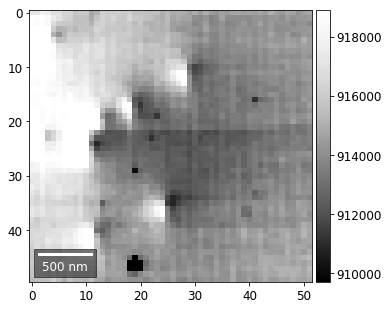

In [20]:
with h5py.File(h5ResultFile, 'r') as h5f:
    bse = h5f['/maps/bse_total']
    plot_SEM(bse, cmap='Greys_r', microns=step_map_microns)

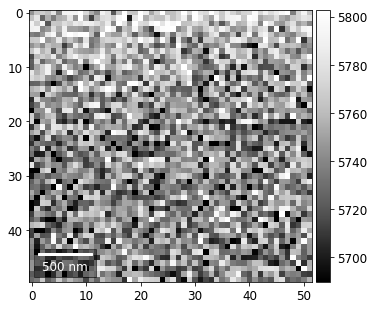

In [21]:
with h5py.File(h5ResultFile, 'r') as h5f:
    kiku = h5f['/maps/kiku_total']
    plot_SEM(kiku, cmap='Greys_r', microns=step_map_microns)

### Intensity in Rows and Columns of the vBSE array

We can calculate additional images from the vBSE data set of 7x7 ROIs derived from the original patterns.
As a first example, we plot the intensities of each of the 7 rows and then of each of the 7 columns: 

#### Rows

Range of Values:  [98411.729767687546, 149717.25413584543]


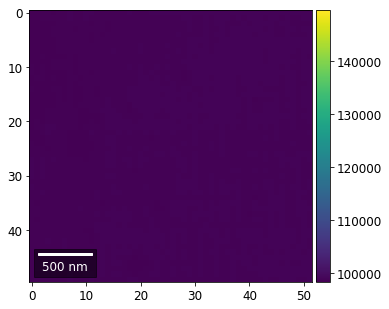

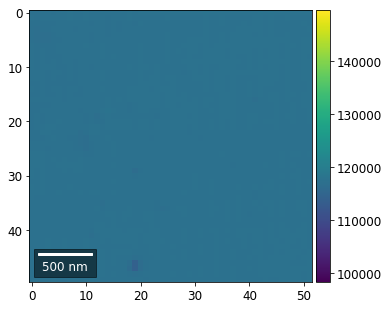

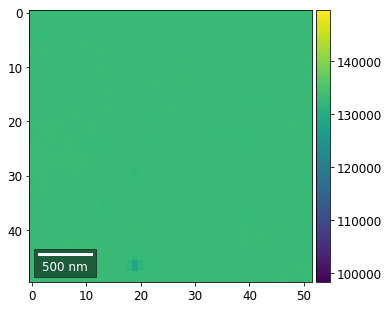

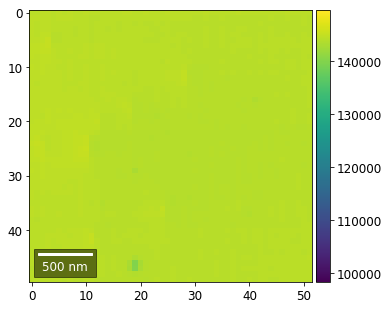

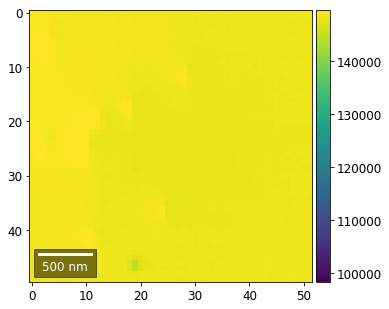

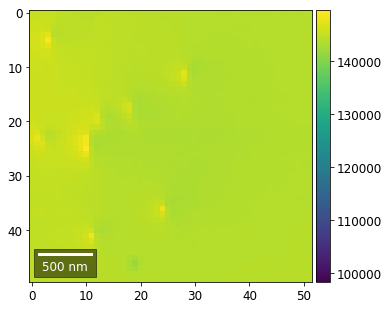

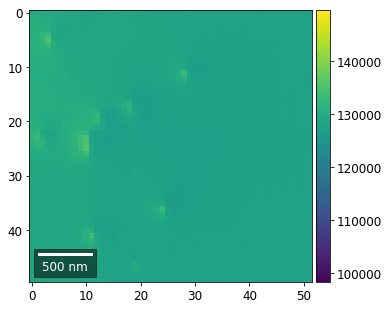

In [22]:
with h5py.File(h5ResultFile, 'r') as h5f:
    vFSD= h5f['vbse']
    
    # signal: sum of row 
    vmin=40000000
    vmax=0

    bse_rows = []

    # (1) get full range for all images
    for row in range(7):
        signal = np.sum(vFSD[:,row,:], axis=1) #/vFSD[:,row+drow,0]
        signal_map = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)
        minv, maxv = get_vrange(signal, stretch=3.0)
        if (minv<vmin):
            vmin=minv
        if (maxv>vmax):
            vmax=maxv    

    # (2) make plots with same range for comparisons of absolute BSE values
    vrange=[vmin, vmax]
    print('Range of Values: ', vrange)
    #vrange=None
    for row in range(7):
        signal = np.sum(vFSD[:,row,:], axis=1) #/vFSD[:,row+drow,0]
        signal_map = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)
        bse_rows.append(signal_map)
        plot_SEM(signal_map, vrange=vrange, filename='vFSD_row_absolute_'+str(row),
                 rot180=True, microns=step_map_microns)

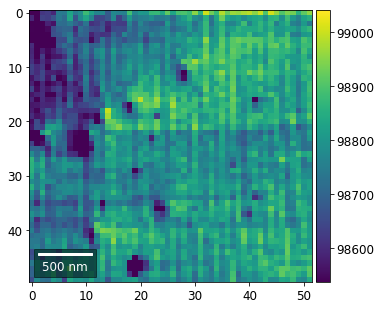

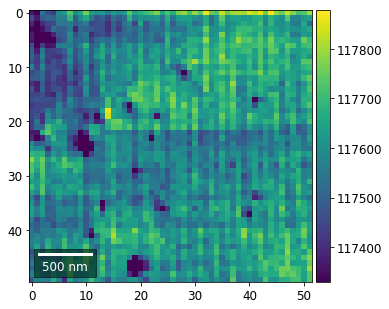

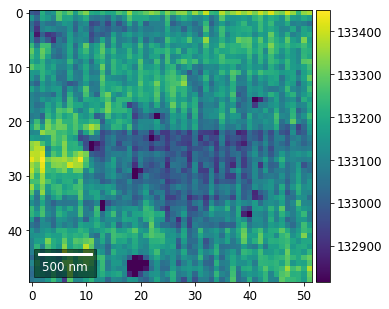

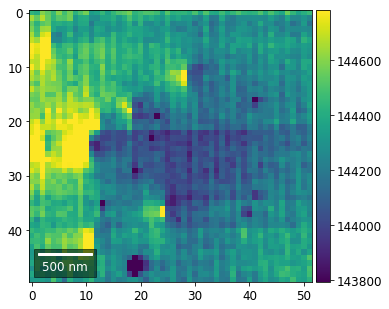

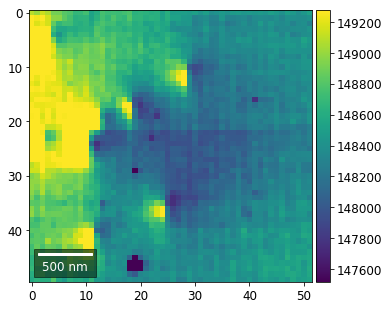

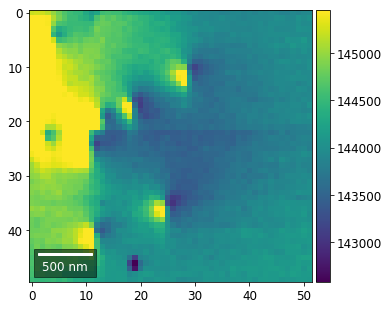

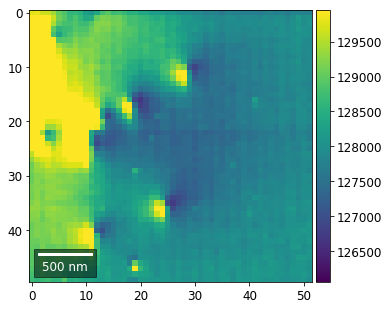

In [23]:
with h5py.File(h5ResultFile, 'r') as h5f:
    vFSD= h5f['vbse']
    # (3) make plots with  individual ranges for better contrast
    vrange=None
    for row in range(7):
        signal = np.sum(vFSD[:,row,:], axis=1) #/vFSD[:,row+drow,0]
        signal_map = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)
        bse_rows.append(signal_map)
        plot_SEM(signal_map, vrange=vrange, filename='vFSD_row_individual_'+str(row),
                 rot180=True, microns=step_map_microns)

#### Columns

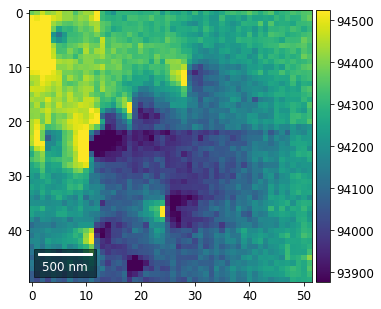

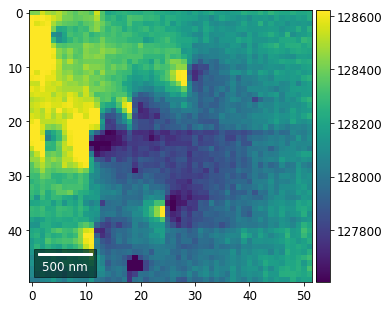

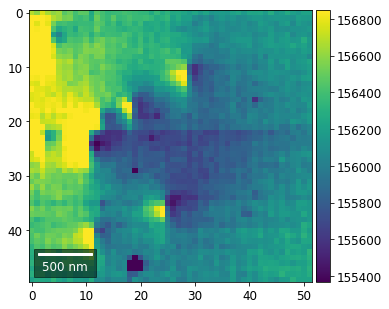

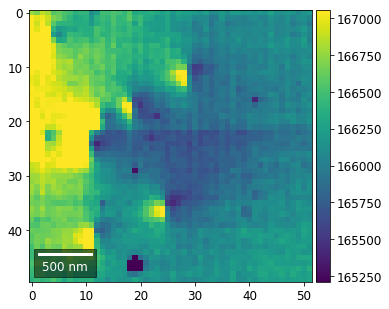

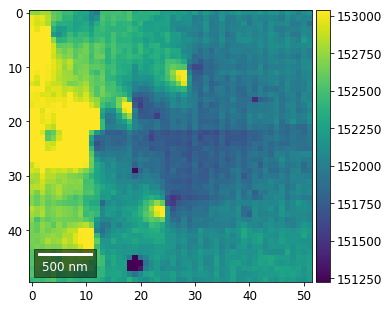

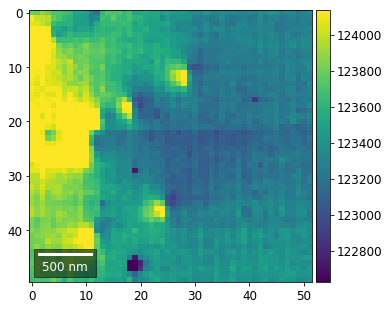

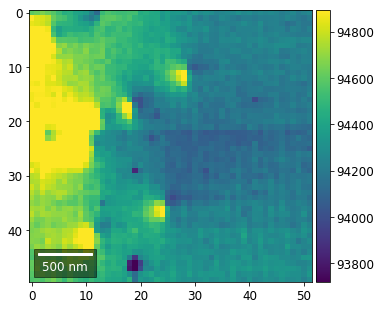

In [24]:
with h5py.File(h5ResultFile, 'r') as h5f:
    vFSD= h5f['vbse']
    # signal: sum of column
    vmin=400000
    vmax=0

    bse_cols = []

    # (1) get full range for all images
    for col in range(7):
        signal = np.sum(vFSD[:,:,col], axis=1) #/vFSD[:,row+drow,0]
        signal_map = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)
        minv, maxv = get_vrange(signal)
        if (minv<vmin):
            vmin=minv
        if (maxv>vmax):
            vmax=maxv    

    # (2) make plots with same range for comparisons of absolute BSE values
    #vrange=[vmin, vmax]
    vrange=None # no fixed scale
    for col in range(7):
        signal = np.sum(vFSD[:,:,col], axis=1) #/vFSD[:,row+drow,0]
        signal_map = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)
        bse_cols.append(signal_map)
        plot_SEM(signal_map, vrange=vrange, filename='vFSD_col_'+str(col),
                 rot180=True, microns=step_map_microns)

### vBSE Color Imaging

We can also form color images by assigning red, green, and blue channels to the left, middle, and right vBSE sensors of a row: 

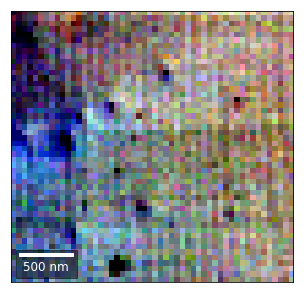

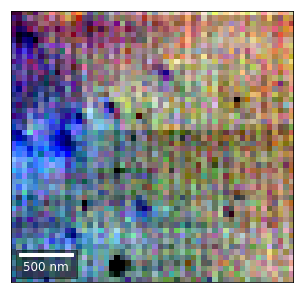

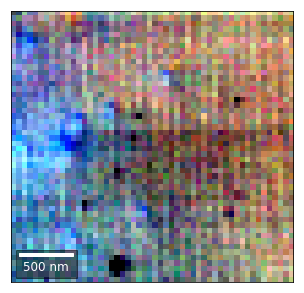

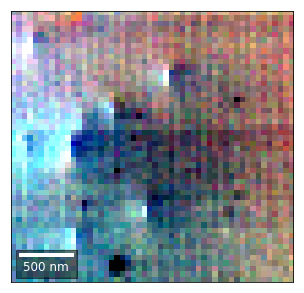

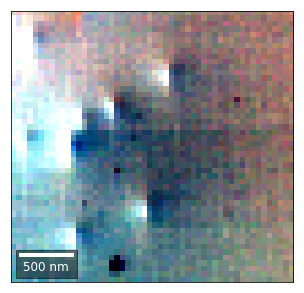

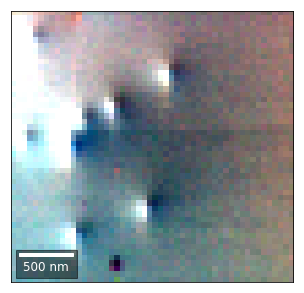

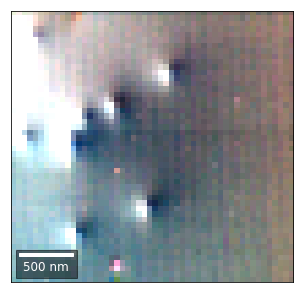

In [25]:
with h5py.File(h5ResultFile, 'r') as h5f:
    vFSD= h5f['vbse']# rgb direct
    rgb_direct = []

    for row in range(7):
        signal = vFSD[:,row,0]
        red = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)

        signal = vFSD[:,row,3]
        green = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)

        signal = vFSD[:,row,6]
        blue = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)

        rgb=plot_SEM_RGB(red, green, blue, MapHeight, MapWidth, 
                         filename='vFSD_RGB_row_'+str(row),
                         rot180=False, microns=step_map_microns,
                         add_bright=0, contrast=0.8)

        rgb_direct.append(rgb)

Differential color signals can be formed by calculating the relative changes to the ROI in the previous row:

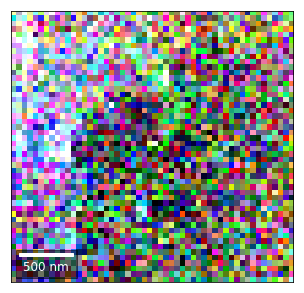

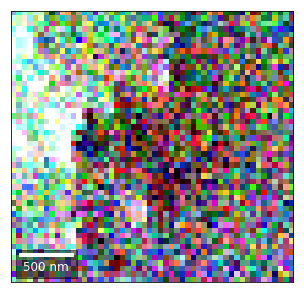

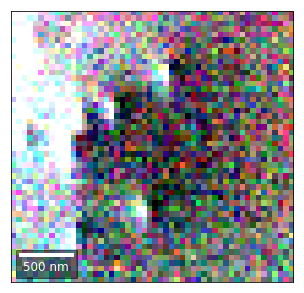

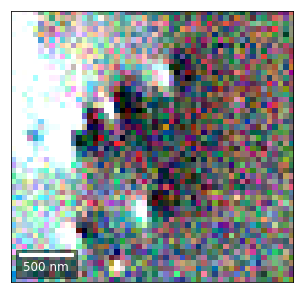

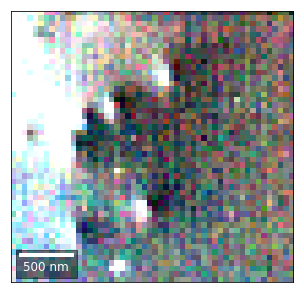

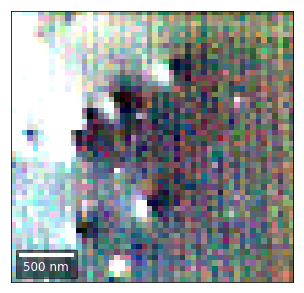

In [26]:
with h5py.File(h5ResultFile, 'r') as h5f:
    vFSD= h5f['vbse']# rgb direct# relative change to previous row
    for row in range(1,7):
        drow = -1
        signal = vFSD[:,row,0]/vFSD[:,row+drow,0]
        red = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)

        signal = vFSD[:,row,2]/vFSD[:,row+drow,2]
        green = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)

        signal = vFSD[:,row,4]/vFSD[:,row+drow,4]
        blue = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)

        rgb=plot_SEM_RGB(red, green, blue, MapHeight, MapWidth, 
                         filename='vFSD_RGB_drow_'+str(row),
                         microns=step_map_microns,
                         rot180=False, add_bright=0, contrast=1.2)

### Kikuchi vBSE Imaging

#### Kikuchi Pattern Array ROI as RGB

Not possible with simple BSE diodes!!!

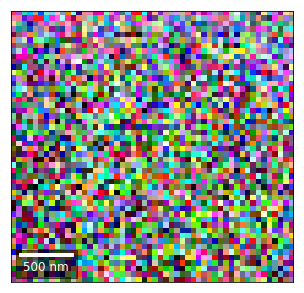

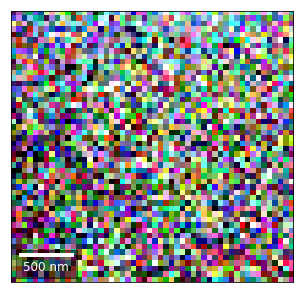

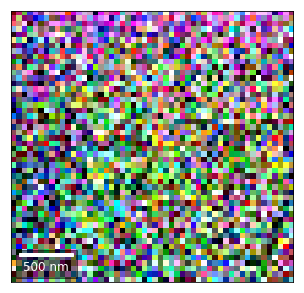

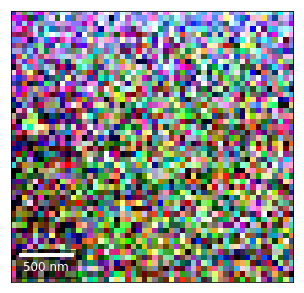

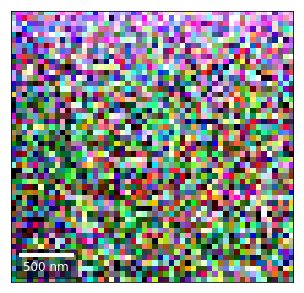

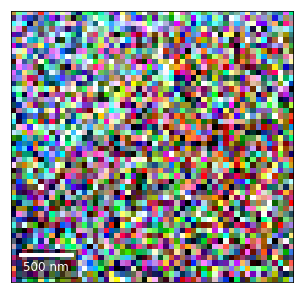

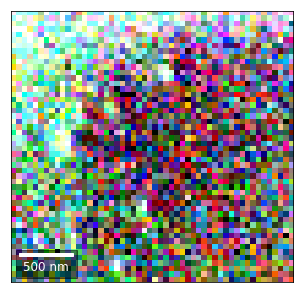

In [27]:
with h5py.File(h5ResultFile, 'r') as h5f:
    vFSD= h5f['vkiku']   

    # rgb direct
    rgb_direct = []

    for row in range(7):
        signal = vFSD[:,row,0]
        red = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)

        signal = vFSD[:,row,3]
        green = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)

        signal = vFSD[:,row,6]
        blue = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)

        rgb=plot_SEM_RGB(red, green, blue, MapHeight, MapWidth, 
                         filename='vKiku_RGB_row_'+str(row),
                         rot180=False, microns=step_map_microns,
                         add_bright=0, contrast=1.2)

        rgb_direct.append(rgb)

#### Differential Kikuchi Imaging

We determine the relative change between Kikuchi Array ROIs and use them as RGB values.
The normalization to a reference ROI reduces the noise that is purely due to the variation of the background and the background processing on the complete pattern.

The colors represent orientation changes via the corresponding changes in ROIs of the Kikuchi patterns and the 7x7 array.

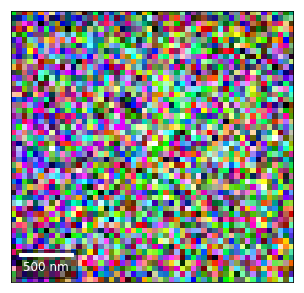

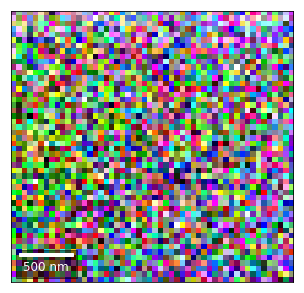

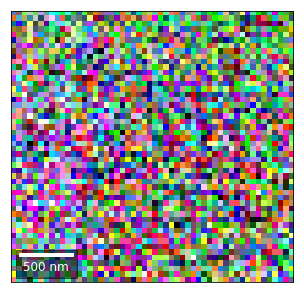

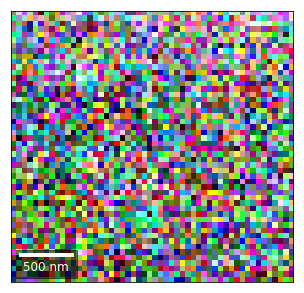

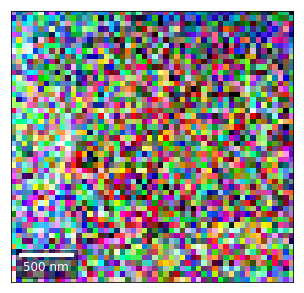

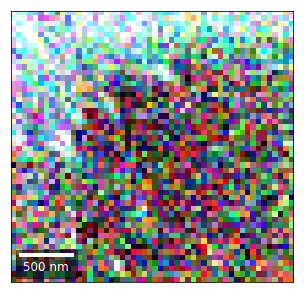

In [28]:
with h5py.File(h5ResultFile, 'r') as h5f:
    vFSD= h5f['vkiku'] 
    # relative change to previous row
    for row in range(1,7):
        drow = -1
        signal = vFSD[:,row,0]/vFSD[:,row+drow,0]
        red = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)

        signal = vFSD[:,row,2]/vFSD[:,row+drow,2]
        green = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)

        signal = vFSD[:,row,4]/vFSD[:,row+drow,4]
        blue = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)

        rgb=plot_SEM_RGB(red, green, blue, MapHeight, MapWidth, 
                         filename='vKiku_RGB_drow_'+str(row),
                         microns=step_map_microns,
                         rot180=False, add_bright=0, contrast=1.2)

## Center of Mass Imaging 

We can interpret the 2D image intensity as a mass density on a plane. The statistical moments of the density distribution (mean, variance, ...) can be used as signal sources. 
In the example below, we use the image center of mass as a signal source.

### COM of Raw Patterns

In [29]:
# calculate the center-of-mass for each pattern, use binning for speed
COMxp, COMyp = arbse.calc_COM_px(Patterns, process=process_bin)

total points: 2600 current: 2600 finished -> total calculation time :    0.1 min 


In [30]:
# save the results in h5ResultFile 
print(h5ResultFile)
with h5py.File(h5ResultFile, 'a') as h5f:
    h5f.create_dataset('/COM/COMxp_vbse', data=COMxp)
    h5f.create_dataset('/COM/COMyp_vbse', data=COMyp)   

arBSE_GaN_Dislocations_1.hdf5


### COM of Kikuchi Patterns

This should be seen with caution, as the background removal process is never perfect and will tend to leave some residual intensity, so that the Kikuchi COM is correlated with the raw pattern COM (which is dominated by the smooth background intensity).

In [31]:
COMxp, COMyp = arbse.calc_COM_px(Patterns, process=process_kikuchi)

total points: 2600 current: 2600 finished -> total calculation time :    0.7 min 


In [32]:
# append to current h5ResultFile
print(h5ResultFile)
with h5py.File(h5ResultFile, 'a') as h5f:
    h5f.create_dataset('/COM/COMxp_kiku', data=COMxp)
    h5f.create_dataset('/COM/COMyp_kiku', data=COMyp)   

arBSE_GaN_Dislocations_1.hdf5


First, we calculate where the COMs are in x,y in pixels in the patterns:

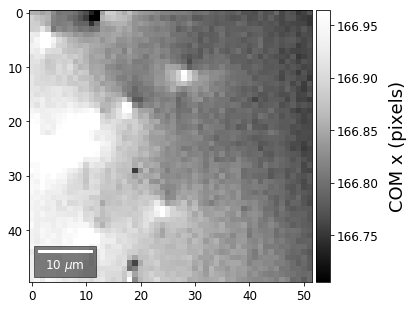

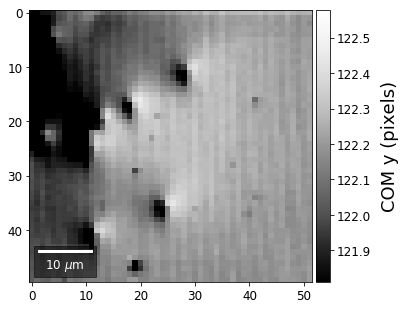

In [33]:
with h5py.File(h5ResultFile, 'r') as h5f:
    COMxp = h5f['/COM/COMxp_vbse']
    COMyp = h5f['/COM/COMyp_vbse']
    
    comx_map0=make2Dmap(COMxp[:],XIndex,YIndex,MapHeight,MapWidth)
    comy_map0=make2Dmap(COMyp[:],XIndex,YIndex,MapHeight,MapWidth)

    plot_SEM(comx_map0, colorbarlabel='COM x (pixels)', cmap='Greys_r')
    plot_SEM(comy_map0, colorbarlabel='COM y (pixels)', cmap='Greys_r')

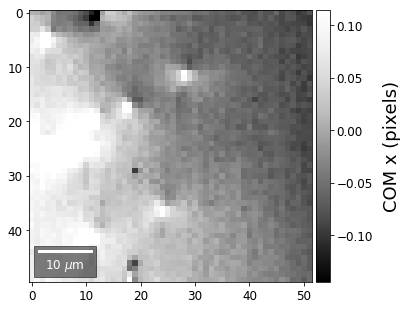

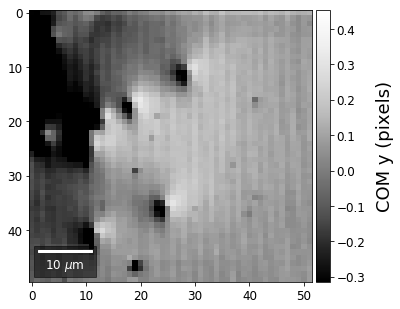

In [34]:
with h5py.File(h5ResultFile, 'r') as h5f:
    COMxp = h5f['/COM/COMxp_vbse']
    COMyp = h5f['/COM/COMyp_vbse']
    
    meanx=np.mean(COMxp)
    meany=np.mean(COMyp)

    comx_map=make2Dmap(COMxp[:]-meanx,XIndex,YIndex,MapHeight,MapWidth)
    comy_map=make2Dmap(COMyp[:]-meany,XIndex,YIndex,MapHeight,MapWidth)

    plot_SEM(comx_map, colorbarlabel='COM x (pixels)', filename='comx', cmap='Greys_r')
    plot_SEM(comy_map, colorbarlabel='COM y (pixels)', filename='comy', cmap='Greys_r')

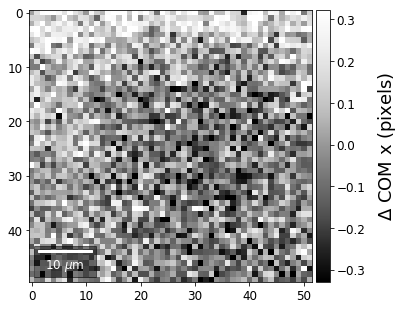

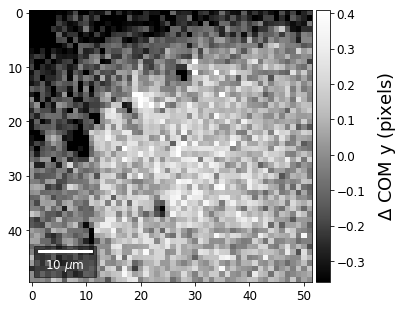

In [35]:
with h5py.File(h5ResultFile, 'r') as h5f:
    COMxp = h5f['/COM/COMxp_kiku']
    COMyp = h5f['/COM/COMyp_kiku']
    meanx = np.mean(COMxp)
    meany = np.mean(COMyp)

    comx_map = make2Dmap(COMxp[:] - meanx, XIndex, YIndex, MapHeight, MapWidth)
    comy_map = make2Dmap(COMyp[:] - meany, XIndex, YIndex, MapHeight, MapWidth)

    plot_SEM(comx_map, colorbarlabel='$\Delta$ COM x (pixels)', filename='comx_kiku', cmap='Greys_r')
    plot_SEM(comy_map, colorbarlabel='$\Delta$ COM y (pixels)', filename='comy_kiku', cmap='Greys_r')